# 07e scATAC LSK Signac ChromVar part1

scATACseq analysis of LSKs using Signac

used this docker image

docker run --rm -d --name signac -p 8880:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work  signac:0.2.5



In [1]:
library(Signac)
library(Seurat)
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)
library(ggplot2)
library(JASPAR2018)
library(TFBSTools)
#library(BSgenome.Mmusculus.UCSC.mm10)
library(tidyverse)
library(data.table)
library(SummarizedExperiment)
library(GenomicRanges)
library(diffloop)
library(tidyverse)
library(diffloop)
library(SingleCellExperiment)
library(rlist)

set.seed(1234)

Warning message:
“package ‘Seurat’ was built under R version 3.6.3”Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading req

In [2]:
combo <- readRDS("./sc_objects/scATAC_combined_macs2.rds")

fragment.path <- "./raw_data/fragments.tsv.gz"

combo <- SetFragments(
  object = combo,
  file = fragment.path
)

combo

An object of class Seurat 
586709 features across 10750 samples within 2 assays 
Active assay: peaks (243581 features, 0 variable features)
 1 other assay present: RNA

In [3]:
combo@assays$RNA <- NULL

In [4]:
# filter to MPPs
filtered <- read.csv('./write/scATAC_MPP_filtered_cells.csv')
lizt1 <- paste0("MPP_", filtered$x) #have to add the MPP_ identifyer
filtered <- read.csv('./write/scATAC_LT_filtered_cells.csv')
lizt2 <- paste0("HSC_", filtered$x) #have to add the HSC_ identifyer

#calculate how many HSCs are needed
n_HSC = round(length(lizt1)/(1-0.019) - length(lizt1))

#subsample
lizt3 = list.sample(lizt2, n_HSC, replace = FALSE, weight = 1, prob = NULL)

lizt = c(lizt1, lizt3)
combo <- SubsetData(combo, cells = lizt)
combo

Warning message:
"'SubsetData' is deprecated.
Use 'subset' instead.
See help("Deprecated")"Warning message:
"'OldWhichCells' is deprecated.
Use 'WhichCells' instead.
See help("Deprecated")"

An object of class Seurat 
243581 features across 8959 samples within 1 assay 
Active assay: peaks (243581 features, 0 variable features)

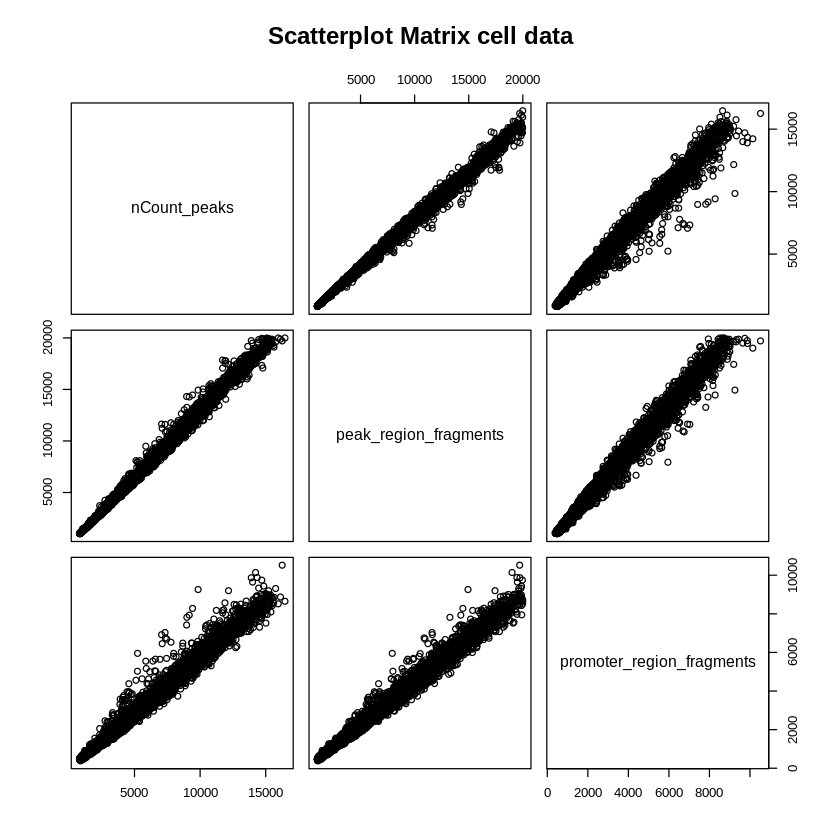

In [5]:
# make column in metadata that denotes the nCounts in th count matrix

nCount_peaks = colSums(x = combo, slot = "counts")
combo$nCount_peaks2 = nCount_peaks

pairs(~nCount_peaks+peak_region_fragments+promoter_region_fragments,data = combo@meta.data,
   main = "Scatterplot Matrix cell data")

In [6]:
combo <- RunTFIDF(combo)
combo <- FindTopFeatures(combo, min.cutoff = 'q5')

combo <- RunSVD(
  object = combo,
  assay = 'peaks',
  reduction.key = 'LSI_',
  reduction.name = 'lsi',
  fastpath=FALSE,
  verbose=TRUE
)

Performing TF-IDF normalization
Running SVD
Scaling cell embeddings


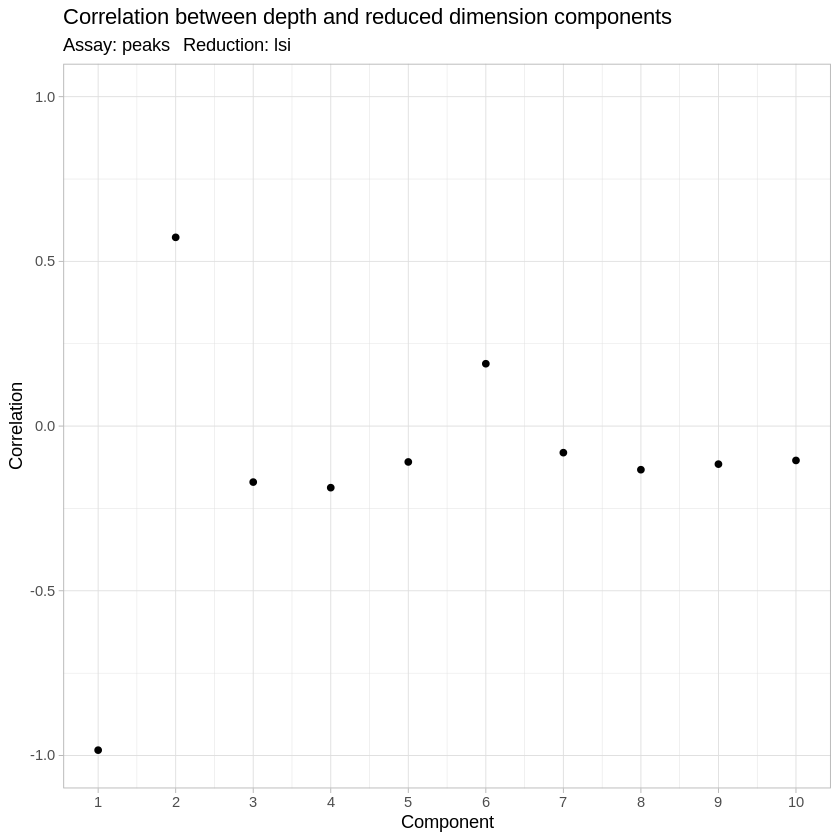

In [7]:
DepthCor(combo)

In [8]:
combo <- FindNeighbors(object = combo, reduction = 'lsi', dims = 2:30, k.param = 30)
combo <- RunUMAP(object = combo, reduction = 'lsi', dims = 2:30)

Computing nearest neighbor graph
Computing SNN
Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"16:48:19 UMAP embedding parameters a = 0.9922 b = 1.112
16:48:19 Read 8959 rows and found 29 numeric columns
16:48:19 Using Annoy for neighbor search, n_neighbors = 30
16:48:19 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
16:48:20 Writing NN index file to temp file /tmp/Rtmpk8rjE2/file309666840e2
16:48:20 Searching Annoy index using 1 thread, search_k = 3000
16:48:23 Annoy recall = 100%
16:48:24 Commencing smooth kNN distance calibration using 1 thread
16:48:26 Initializing from normalized Lap

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

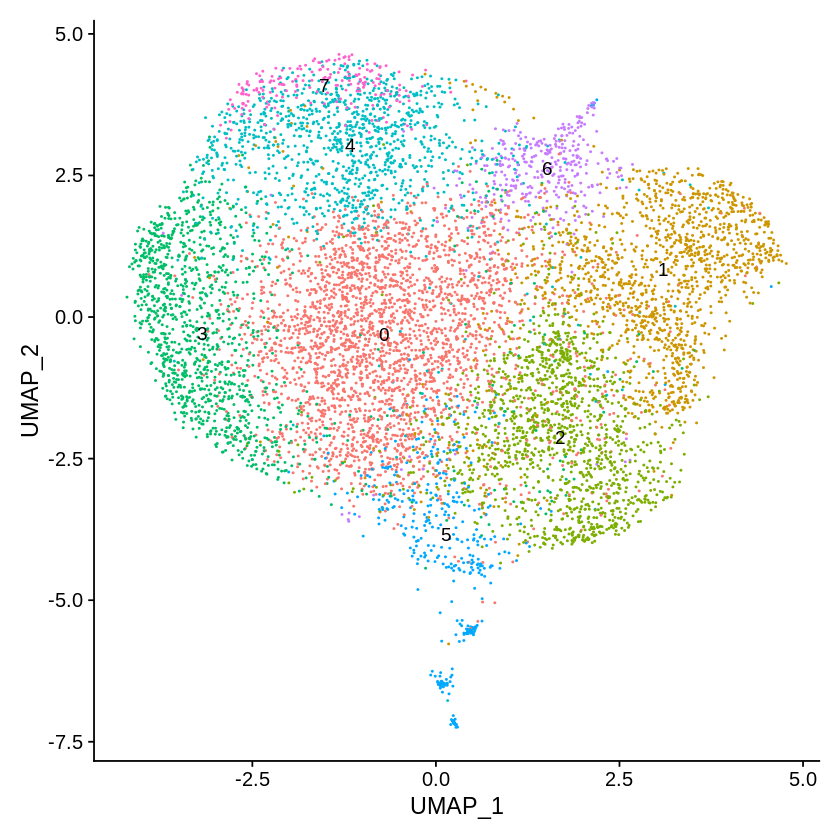

In [9]:
combo <- FindClusters(object = combo, verbose = FALSE, resolution = 0.6, algorithm = 2)
DimPlot(object = combo, label = TRUE) + NoLegend()

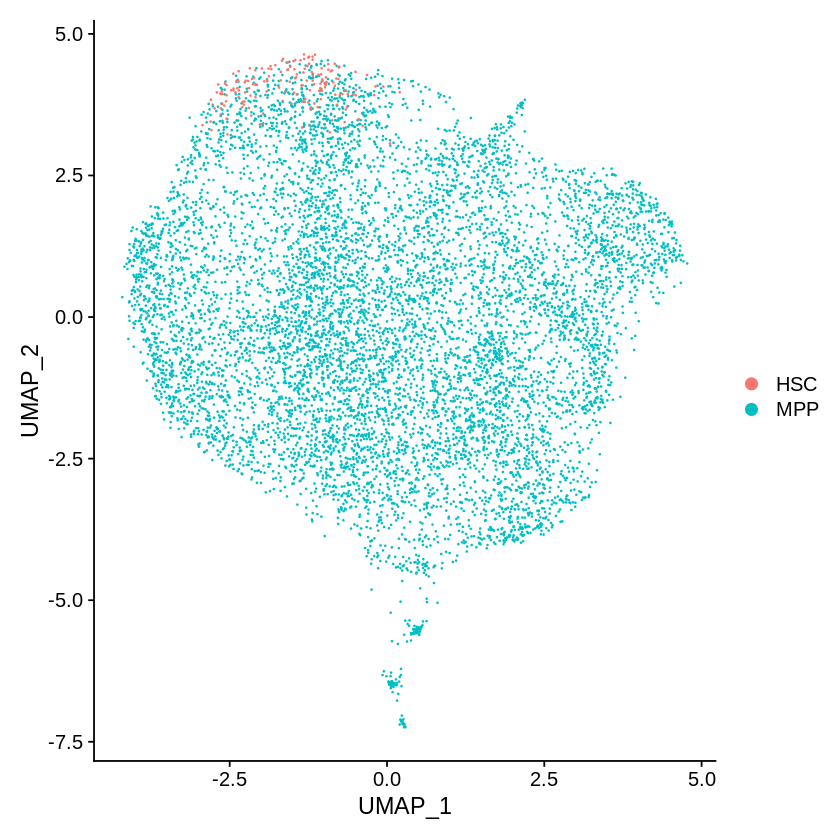

In [10]:
DimPlot(combo, group.by = 'dataset', pt.size = 0.1)

In [11]:
combo

An object of class Seurat 
243581 features across 8959 samples within 1 assay 
Active assay: peaks (243581 features, 232535 variable features)
 2 dimensional reductions calculated: lsi, umap

In [13]:
# add information about male cells as metainfomation
DefaultAssay(combo) <- 'peaks'
counts_df <- GetAssayData(object = combo, slot = "counts")
male_counts <- colSums(counts_df[243553:243581,])
combo$male <- male_counts
combo$male_binary <- combo$male
combo$male_binary[combo$male_binary > 0] <- 1

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
"The following requested variables were not found: nucleosome_percentile, TSS.enrichment"

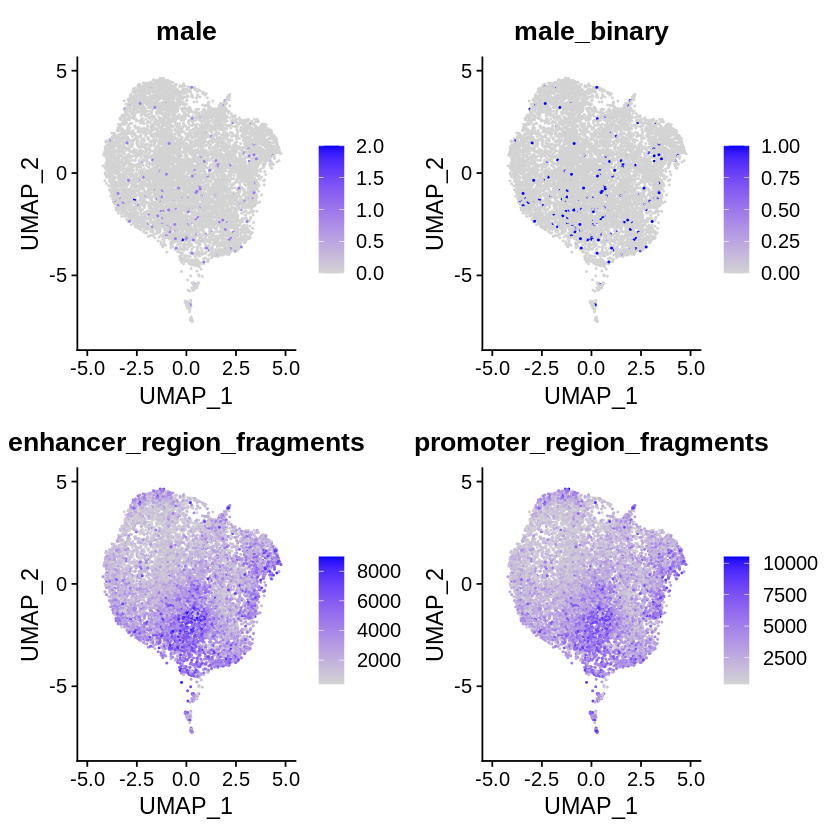

In [14]:
# plot some general stats about cells

FeaturePlot(combo, features = c("male", 
                               "male_binary", 
                               "nucleosome_percentile", 
                               'TSS.enrichment', 
                               'enhancer_region_fragments',
                               'promoter_region_fragments'
                               ), ncol = 2)

In [15]:
#extract gene coordinates from Ensembl, and ensure name formatting is consistent with  Seurat object 
gene.coords <- genes(EnsDb.Mmusculus.v79, filter = ~ gene_biotype == "protein_coding")
seqlevelsStyle(gene.coords) <- 'UCSC'
genebody.coords <- keepStandardChromosomes(gene.coords, pruning.mode = 'coarse')
genebodyandpromoter.coords <- Extend(x = gene.coords, upstream = 2000, downstream = 0)

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 3 out-of-bound ranges located on sequences
  JH584293.1, JH584295.1, and JH584296.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information."

In [16]:
# build a gene by cell matrix
gene.activities <- FeatureMatrix(
  fragments = fragment.path,
  features = genebodyandpromoter.coords,
  cells = colnames(combo),
  chunk = 10
)

Extracting reads overlapping genomic regions
Constructing matrix


In [17]:
# convert rownames from chromsomal coordinates into gene names
gene.key <- genebodyandpromoter.coords$gene_name
names(gene.key) <- GRangesToString(grange = genebodyandpromoter.coords)
rownames(gene.activities) <- make.unique(gene.key[rownames(gene.activities)])
gene.activities <- gene.activities[rownames(gene.activities)!="",]

#Add the gene activity matrix to the Seurat object as a new assay, and normalize it
combo[['RNA']] <- CreateAssayObject(counts = gene.activities)
combo <- NormalizeData(
  object = combo,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(combo$nCount_RNA)
)

In [18]:
DefaultAssay(combo) <- 'RNA'
combo.markers <- FindAllMarkers(combo, only.pos = FALSE, min.pct = 0.05, logfc.threshold = 0.20)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Warning message:
"The following tests were not performed: "Warning message:
"When testing 0 versus all:
	No features pass logfc.threshold threshold"Warning message:
"When testing 1 versus all:
	No features pass logfc.threshold threshold"Warning message:
"When testing 2 versus all:
	No features pass logfc.threshold threshold"

In [19]:
combo.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_logFC)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
3.206747e-35,-0.2358389,0.339,0.519,6.907654e-31,3,Fosb
2.689872e-34,0.2074367,0.777,0.663,5.794253e-30,3,Cables1
4.033075e-27,-0.2186174,0.328,0.479,8.687646e-23,3,Hsph1
1.849082e-07,0.2231187,0.622,0.771,3.983108e-03,4,Prdm16
3.003125e-66,0.2533550,0.469,0.138,6.469032e-62,5,Ikzf3
3.972795e-29,0.2225875,0.596,0.289,8.557798e-25,5,Tnfaip3
1.211849e-07,-0.2012630,0.904,0.812,2.610444e-03,5,Ctif
5.488350e-05,-0.2083412,0.755,0.658,1.000000e+00,5,Ccser1
6.460188e-05,-0.2094476,0.760,0.675,1.000000e+00,5,Cables1


In [20]:
print('combo.markers - all markers')
print((combo.markers) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

[1] "combo.markers - all markers"
   n
1 55


don't have markers - looked at peaks and motifs
0 - endothelium development? no enrichment of any motif
1 - ? depleted of ctcf
2 - proliferation - cell cycle/dna methylation?, depleted of ap one but twist and tal1 there


3 - CABLES1 is expressed in immature hematopoietic progenitor cells - really enriched for Ap-1 https://www.sciencedirect.com/science/article/pii/S2213671119302280
4 - Prdm16 HSC marker https://ashpublications.org/blood/article/117/19/5057/20982/Prdm16-is-a-physiologic-regulator-of-hematopoietic, foxo tf

5- Ikzf3 lymphoid?
6 - erythroid - Gypc, could also be megakaryocyte esp because of Pbx1
7 - HSC enriched https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5596002/



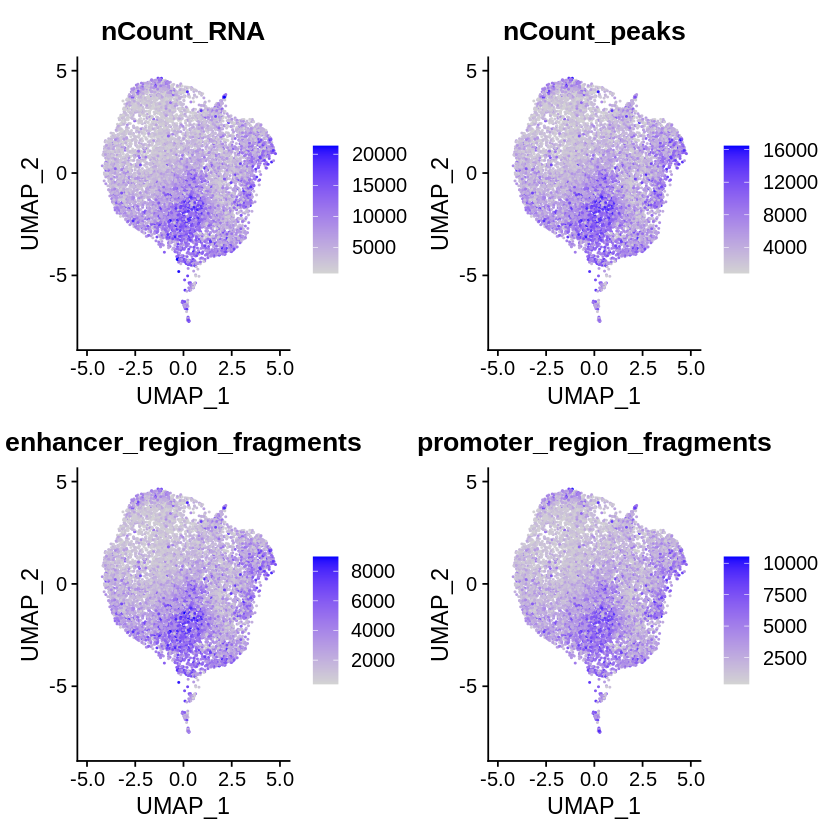

In [21]:
FeaturePlot(combo, features = c("nCount_RNA", 
                               "nCount_peaks",
                             'enhancer_region_fragments',
                             'promoter_region_fragments'
                             
                               ), ncol = 2)

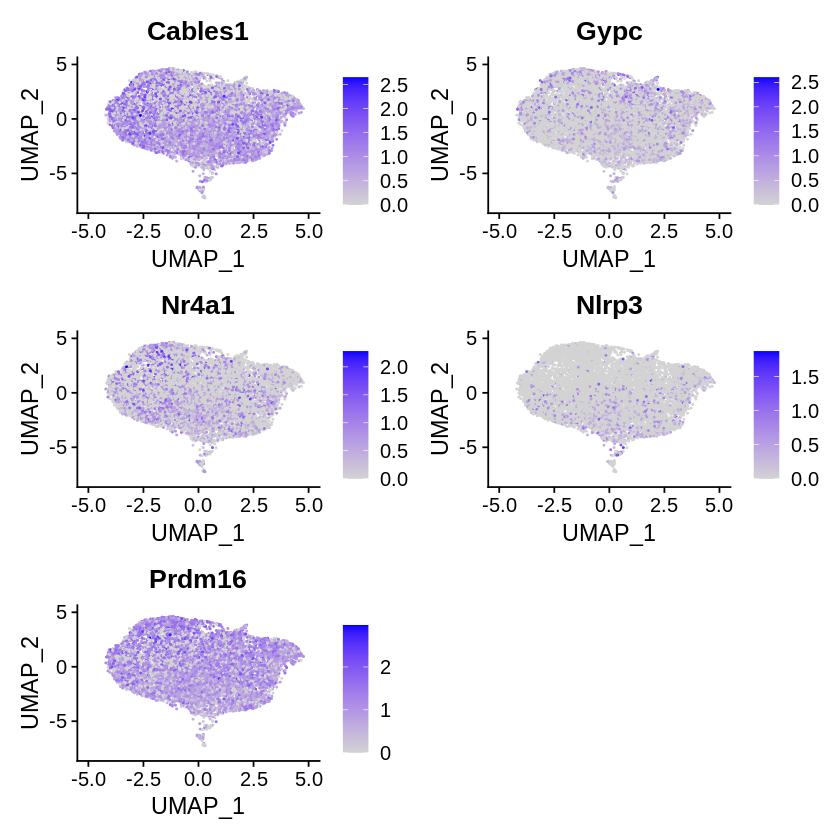

In [22]:
DefaultAssay(combo) <- 'RNA'
FeaturePlot(
  object = combo,
  features = c('Cables1', 'Gypc','Nr4a1', 'Nlrp3', 'Prdm16'),
  ncol = 2,
)

In [ ]:
DefaultAssay(combo) <- 'peaks'

combo.peaks <- FindAllMarkers(combo, 
                             only.pos = TRUE, 
                             min.pct = 0.05, 
                             logfc.threshold = 0.2,
                             test.use = 'LR',
                             latent.vars = 'nCount_peaks')

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6


In [ ]:
head(combo.peaks)

In [ ]:
print('combo.peaks - all markers')
print((combo.peaks) %>% filter(p_val_adj < 0.05) %>% summarise(n = n()))

In [ ]:
# create granges object with TSS positions
gene.ranges <- genes(EnsDb.Mmusculus.v79)
seqlevelsStyle(gene.ranges) <- 'UCSC'
gene.ranges <- gene.ranges[gene.ranges$gene_biotype == 'protein_coding', ]
gene.ranges <- keepStandardChromosomes(gene.ranges, pruning.mode = 'coarse')

In [ ]:
# annotate all combo.peaks with closest gene

peaks_all_df <- (combo.peaks[combo.peaks$p_val_adj < 0.05, ])
peaks_all <- rownames(peaks_all_df)
closest_all <- ClosestFeature(regions = peaks_all, annotation = gene.ranges, sep = c(':', '-'))
peaks_all_df$query_region <- rownames(peaks_all_df) # makes index to column
peaks_all_df <- merge(peaks_all_df, closest_all, by = 'query_region')

In [ ]:
# this is how to extract the genes that are close to the differentially expressed peaks

peaks_2 <- (combo.peaks %>% filter(avg_logFC > 0.25 & cluster == "2"))$gene
closest_2 <- ClosestFeature(regions = peaks_2, annotation = gene.ranges, sep = c(':', '-'))
head(closest_2)

In [ ]:
## save csvs of enrichments

write.csv(combo.markers %>% filter(p_val_adj < 0.05),'./write/combo_markers_macs2.csv')
write.csv(peaks_all_df %>% filter(p_val_adj < 0.05),'./write/combo_peaks_macs2.csv')

In [ ]:
### save MMP object

saveRDS(combo, file = "./sc_objects/scATAC_combo_processed_macs2.rds")

In [ ]:
sessionInfo()